In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


#Задача 4

Рассматриваем процесс $Y_t = Y_0 + c\cdot t + \sum_{j=1}^{N_t} \eta_j,\ N_t \sim Pois(t), \eta_j \sim R[100, 200].$ Согласно теореме для марковского момента 
$\tau = \{t : Y_t < 0\}$ справедливо: 
$$ P(\tau < +\infty) < e^{-Y_0\cdot v_0},$$
где $v_0$ - корень уравнения:
$$ g(v) = Ee^{v\eta} - 1 - c\cdot v = 0.$$

В нашем случае $g(v) = \frac{1}{100v}(e^{200v} - e^{100v})- 1 - c\cdot v$

Посчитаем матожидание $Y_t:$
$$\mathsf{E} Y_t = Y_0 + c \cdot t - \mathsf{E}\left(\sum_{j=0}^{N_t} \eta_j\right) = Y_0 + c \cdot t - \sum_{j=0}^{+\infty} \frac{e^{-t}}{k!} \cdot k \cdot \mathsf{E}\eta_j = Y_0 + c \cdot t -t \cdot 150$$

Взяв $Y_0 = 10 \cdot c$, получаем уравнение на t:
$ c \geqslant \frac{150\cdot t}{t + 10},$ значит $\ c \geqslant 150.$ Убедимся в этом, нарисуя график $f(x) = \frac{150 \cdot x}{x + 10}.$

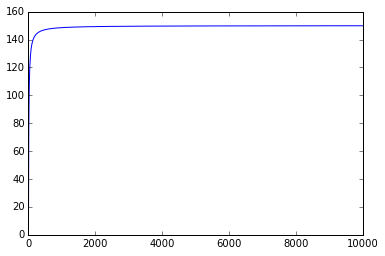

In [7]:
def f(x):
    return 150.*x/(x + 10.)

X = linspace(0, 10000, 1000)
plt.figure()
plt.plot(X, [f(x) for x in X])
plt.show()

Напишем функцию, вычисляющую теоретическу оценку на вероятность вырождения.

In [10]:
def calc_g(v, c):
    return (1/(100. * v))*(np.exp(200 * v) - np.exp(100 * v)) - 1 - c * v

def find_decision(c=100000, precision=0.001):
    start = 0.
    end = 5.
    while (calc_g(end, c) < 0):
        end = end + 1
        
    while end - start > precision:
        med = (start + end)/2.
        if calc_g(med,c) > 0:
            end = med
        else:
            start = med
    #print "start= ", start
    return end

def est_bankcrupt_prob(y_0, c=100000, precision=0.0000000001):
    v_0 = find_decision(c, precision)
    return np.exp(-y_0 * v_0)

Напишем функцию, которая с помощью бинпоиска вычисляет оптимальные параметры $c$ и $Y_0.$

In [17]:
def find_appropriate_parametres(c_start, c_end, c_precision = 0.001, estimation = 0.1, with_developing=True, Y_0=200):
    while c_end - c_start > c_precision:
        c_med = (c_start + c_end) / 2.
        if with_developing == True:
            y_0 = 10 * (c_med - 140)
            #print c_med, y_0
        else:
            y_0 = Y_0
        prob = est_bankcrupt_prob(y_0, c = c_med)
        if prob > estimation:
            c_start = c_med
        else:
            c_end = c_med
    return (c_start, y_0)

Построим график зависимости скорости поступления капитала от начального капитала при теоретической оценке банкроства 10%, 5%, 1%.

/home/anya/ipython-env/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from IPython.kernel.zmq import kernelapp as app


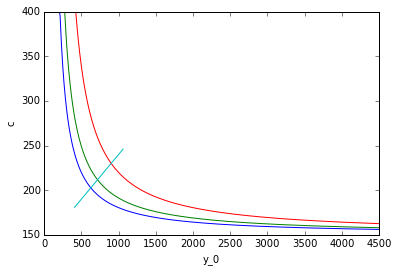

In [48]:
y_0 = linspace(100, 4500, 500)
c_10 = [find_appropriate_parametres(141,400,  with_developing=False, Y_0 = y)[0] for y in y_0]
c_5 = [find_appropriate_parametres(141,400,  estimation=0.05, with_developing=False, Y_0 = y)[0] for y in y_0]
c_1 = [find_appropriate_parametres(141,400,  estimation=0.01, with_developing=False, Y_0 = y)[0] for y in y_0]
plt.figure()
plt.plot(y_0,c_10)
plt.plot(y_0,c_5)
plt.plot(y_0,c_1)
plt.plot(y_0[35:110], [140 + 0.1 * y for y in y_0[35:110]])
plt.xlabel('y_0')
plt.ylabel('c')
plt.show()

По графику видно, что оптимально брать $c$ и $Y_0$ на голубой линии, то есть $y_0 = 10 \cdot (c - 140)$, потому что в этом случае скорость и начальный капитал не так сильно коррелируют (возможно, стоит брать голубую линию еще ниже).

Найдем подходящие параметры $Y_0$ и $с$ при вероятности банкротства не более 10%, 5%, 1%. 
Параметр $c$ ищем бинпоиском.

In [19]:
print "для 10%:", find_appropriate_parametres(140, 300, estimation=0.1)
print "для 5%:", find_appropriate_parametres(140, 300, estimation=0.05)
print "для 1%:", find_appropriate_parametres(140, 300, estimation=0.01)

для 10%: (202.71484375, 627.154541015625)
для 5%: (211.7681884765625, 717.681884765625)
для 1%: (230.1019287109375, 901.019287109375)


/home/anya/ipython-env/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from IPython.kernel.zmq import kernelapp as app


Смоделируем процессы при найденных параметрах для оценок на вероятность вырождения 20%, 10%, 5%, 1%.

In [21]:
def model_process(y_0, c, period=100, estimation=0.1):
    X = linspace(1, period + 1, period * 2)
    Y = []
    time_to_pay = sps.expon(1).rvs(1)[0]
    payments_sum = 0
    for t in X:
        y_t = y_0 + c * t 
        while time_to_pay < t:
            time_to_pay = time_to_pay + sps.expon(scale=1).rvs(1)[0]
            payments_sum = payments_sum + sps.uniform(100,100).rvs(1)[0]
        y_t = y_t - payments_sum
        Y.append(y_t)

    plt.figure(figsize=(15,6))
    title = 'Insurance model of Cramer - Lundberg, c = ' + str(round(c,2)) + ' y_0 = ' + str(round(y_0,2)) + ', bankcrupt probability - ' + str(estimation)
    plt.title(title)
    plt.plot(X, Y)
    plt.xlim(0, period + 10)
    plt.grid()
    plt.show()

/home/anya/ipython-env/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from IPython.kernel.zmq import kernelapp as app


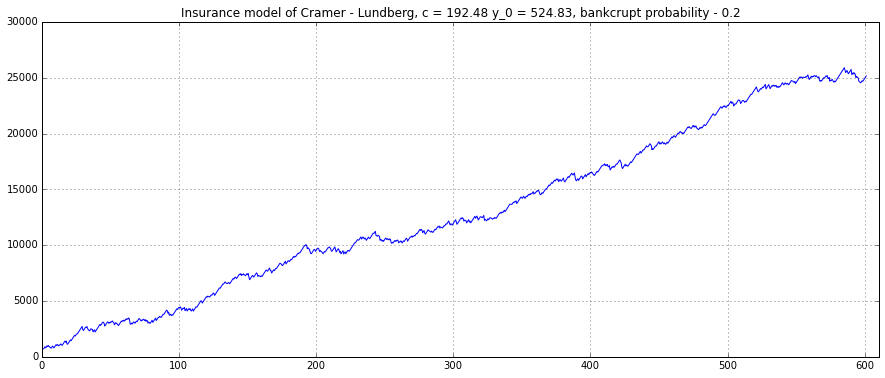

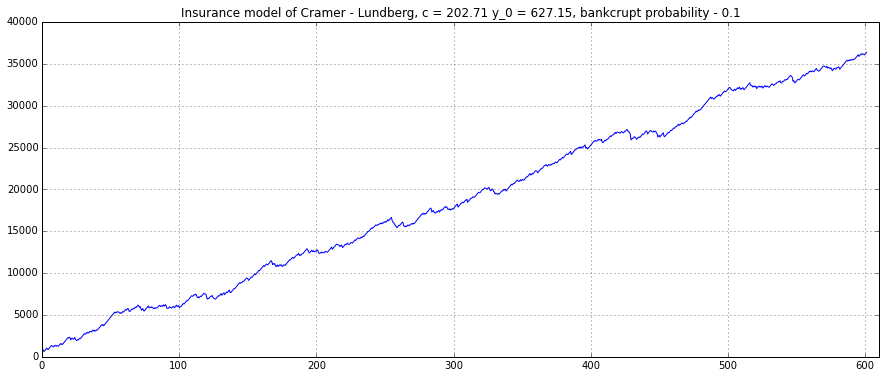

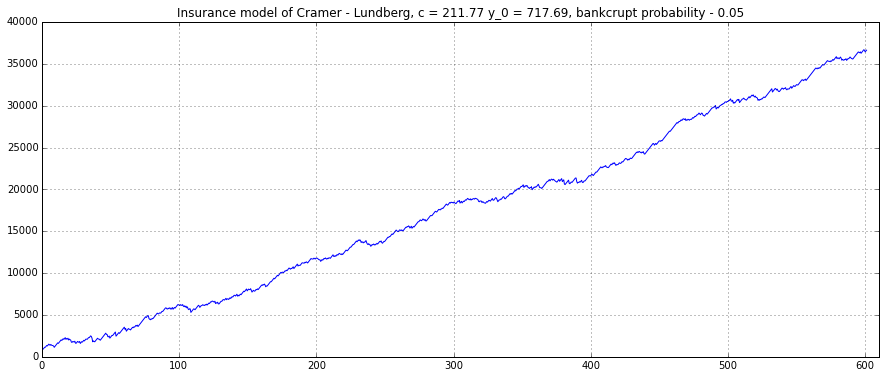

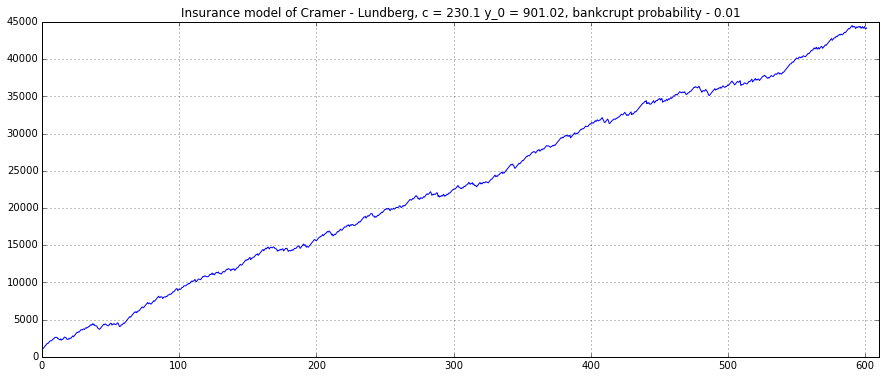

In [22]:
parametres = find_appropriate_parametres(141, 300, estimation=0.2)
model_process(parametres[1], parametres[0], period=600, estimation=0.2)

parametres = find_appropriate_parametres(141, 300, estimation=0.1)
model_process(parametres[1], parametres[0], period=600, estimation=0.1)

parametres = find_appropriate_parametres(141, 300, estimation=0.05)
model_process(parametres[1], parametres[0], period=600, estimation=0.05)


parametres = find_appropriate_parametres(141, 300, estimation=0.01)
model_process(parametres[1], parametres[0], period=600, estimation=0.01)

## Число банкротств для теоретической оценки на вероятность вырождения 10 %

In [26]:
period = 300
number_bankcrupts = 0
parametres = find_appropriate_parametres(100, 200, estimation=0.1)
bankcrupt_moment = 0.
for i in range(500):
    X = linspace(1, period + 1, period * 2)
    time_to_pay = sps.expon(1).rvs(1)[0]
    payments_sum = 0
    for t in X:
        y_t = parametres[1] + parametres[0] * t 
        while time_to_pay < t:
            time_to_pay = time_to_pay + sps.expon(scale=1).rvs(1)[0]
            payments_sum = payments_sum + sps.uniform(100,100).rvs(1)[0]
        y_t = y_t - payments_sum
        if y_t < 0:
            number_bankcrupts = number_bankcrupts + 1
            bankcrupt_moment = bankcrupt_moment + t
            break
            
bankcrupt_moment = bankcrupt_moment/number_bankcrupts

/home/anya/ipython-env/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from IPython.kernel.zmq import kernelapp as app


In [28]:
print "Оценка на вероятность банкротства:", round(number_bankcrupts/300.,2), ", средний момент банкротства: ", bankcrupt_moment

Оценка на вероятность банкротства: 0.06 , средний момент банкротства:  20.1790238633


## Изменение цены страховых взносов

Выберем $T = 20,$ так как это средний момент банкротства из предыдущего пункта. Останавливая процесс в момент $T$, мы получаем исходную задачу с параметром $\tilde Y_0 = Y_{20}.$ Построим несколько графиком, меняя $c$ при $t = 20.$

In [46]:
def model_process_with_T_stop(Y_0, C, period=250, estimation=0.1):
    T = 20
    X = linspace(1, period + 1, period * 3)
    Y = []
    y_0 = Y_0
    c = C
    was_corrected = False
    time_to_pay = sps.expon(1).rvs(1)[0]
    payments_sum = 0
    for t in X:
        if int(t) == T and not was_corrected:
            #print "here"
            was_corrected = True
            c = find_appropriate_parametres(141, 300, with_developing=False, Y_0=Y[-1])[0]
            y_0 = Y[-1]
            time_to_pay = time_to_pay - T
            payments_sum = 0
        
        if was_corrected:
            t = t - T
        
        y_t = y_0 + c * t 
        while time_to_pay < t:
            time_to_pay = time_to_pay + sps.expon(scale=1).rvs(1)[0]
            payments_sum = payments_sum + sps.uniform(100,100).rvs(1)[0]
        y_t = y_t - payments_sum
        Y.append(y_t)

    plt.figure(figsize=(15,6))
    #title = 'Insurance model of Cramer - Lundberg, c_old = ' + str(round(C,2)) + ' ,c_new = ' + str(round(c,2)) + ' ,Y_0 = ' + str(round(Y_0,2)) 
    #plt.title(title)
    plt.plot(X, Y)
    plt.plot([T,T], [0, max(Y) + 100])
    plt.xlim(0, period + 10)
    plt.grid()
    plt.show()

/home/anya/ipython-env/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from IPython.kernel.zmq import kernelapp as app


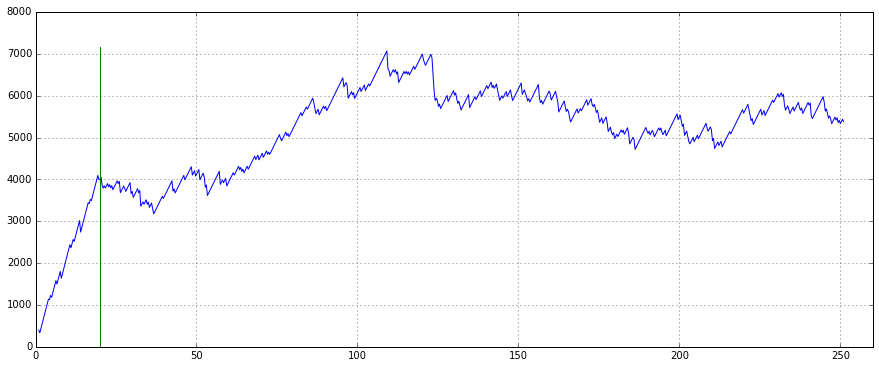

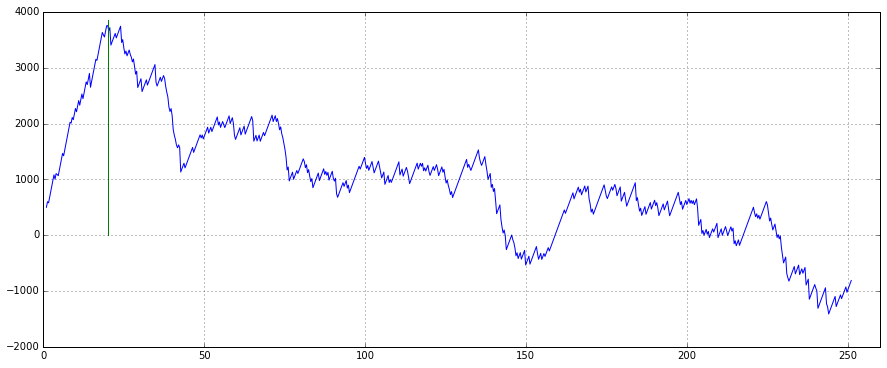

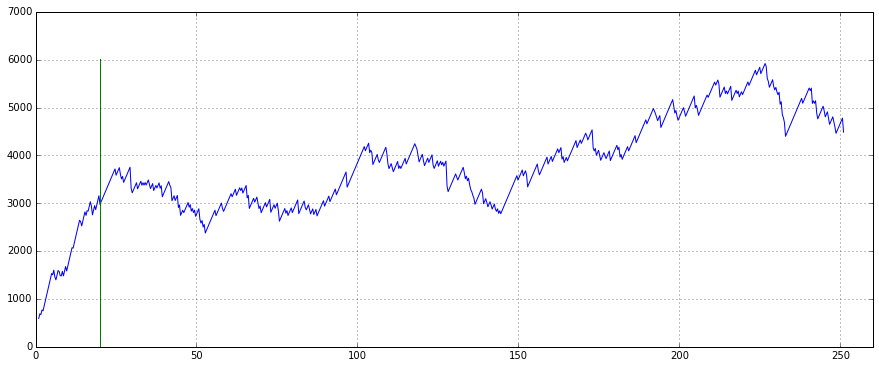

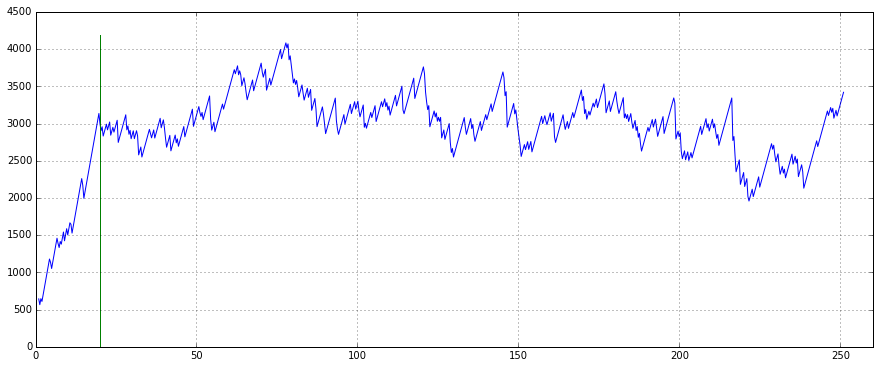

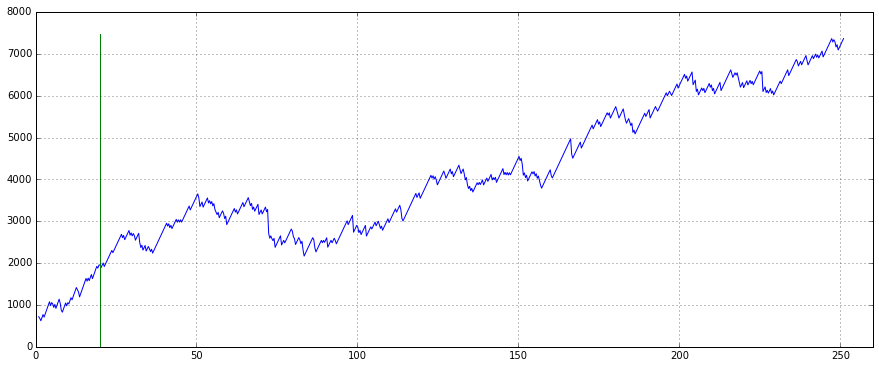

In [47]:
for i in range(5):
    c = find_appropriate_parametres(141, 300, estimation=0.1, with_developing=False, Y_0 = (i+1)*100)[0]
    model_process_with_T_stop((i+1)*100, c, estimation=0.1)

Как видно в графиков, в большинстве случаев изменение цены взносов возможно.